In [1]:
!pip install pydot
!pip install graphviz

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings("ignore")

import pydot
import graphviz

In [3]:
path = 'lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
classes

['lung_aca', 'lung_n', 'lung_scc']

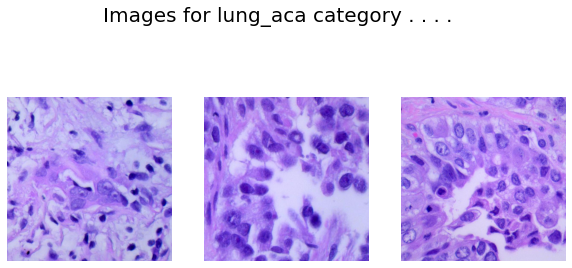

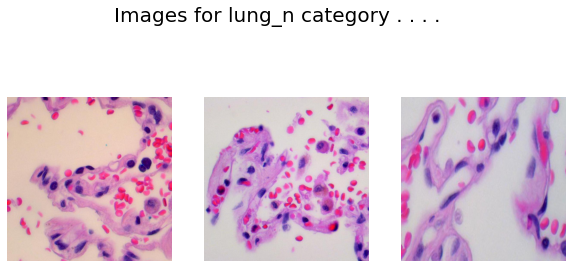

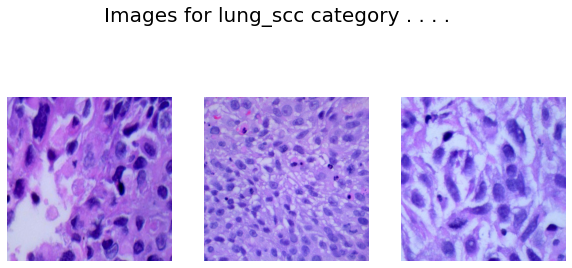

In [4]:
for cat in classes:
    img_dir = f'{path}/{cat}'
    images = os.listdir(img_dir)
    
    fig, ax = plt.subplots(1, 3, figsize=(10,5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
    
    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [5]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

In [6]:
X = []
Y = []

for i, cat in enumerate(classes):
    images = glob(f'{path}/{cat}/*.jpeg')
    
    for image in images:
        img = cv2.imread(image)
        
        X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
        Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, one_hot_encoded_Y,test_size = SPLIT,random_state = 2022)
print(X_train.shape, X_test.shape)

(12000, 256, 256, 3) (3000, 256, 256, 3)


In [8]:
model = keras.models.Sequential([
    layers.Conv2D(filters=32,
                  kernel_size=(5, 5),
                  activation='relu',
                  input_shape=(IMG_SIZE,IMG_SIZE,3),
                  padding='same'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(filters=64,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(filters=128,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 128)      0

In [10]:
keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_activations=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [11]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [12]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached upto 90% so, stopping further training.')
            self.model.stop_training = True
            
es = EarlyStopping(patience=3,monitor='val_accuracy',restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_loss',patience=2,factor=0.5,verbose=1)

In [13]:
history = model.fit(X_train, Y_train,validation_data = (X_test, Y_test),batch_size = BATCH_SIZE,epochs = EPOCHS,verbose = 1,callbacks = [es, lr, myCallback()])

Epoch 1/10
188/188 [==============================] - 1019s 5s/step - loss: 0.3769 - accuracy: 0.8442 - val_loss: 2.2958 - val_accuracy: 0.4950 - lr: 0.0010
Epoch 2/10
188/188 [==============================] - 902s 5s/step - loss: 0.2515 - accuracy: 0.9033 - val_loss: 0.5879 - val_accuracy: 0.8460 - lr: 0.0010
Epoch 3/10
188/188 [==============================] - 834s 4s/step - loss: 0.1921 - accuracy: 0.9233 - val_loss: 0.3755 - val_accuracy: 0.8600 - lr: 0.0010
Epoch 4/10
188/188 [==============================] - 1316s 7s/step - loss: 0.1528 - accuracy: 0.9386 - val_loss: 0.9038 - val_accuracy: 0.7857 - lr: 0.0010
Epoch 5/10
188/188 [==============================] - ETA: 0s - loss: 0.1227 - accuracy: 0.9525
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
188/188 [==============================] - 786s 4s/step - loss: 0.1227 - accuracy: 0.9525 - val_loss: 6.4131 - val_accuracy: 0.3447 - lr: 0.0010
Epoch 6/10
188/188 [==============================] - 803

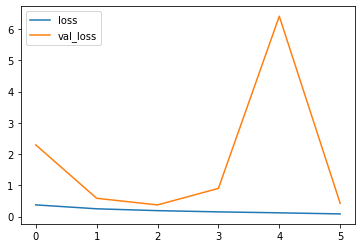

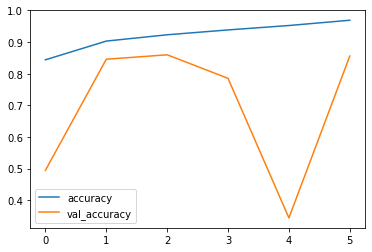

In [14]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

In [15]:
Y_pred = model.predict(X_test)
Y_test = np.argmax(Y_test, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

94/94 [==============================] - 28s 287ms/step


In [16]:
metrics.confusion_matrix(Y_test, Y_pred)

array([[ 605,   58,  324],
       [   2,  974,    1],
       [  35,    0, 1001]], dtype=int64)

In [17]:
print(metrics.classification_report(Y_test, Y_pred,target_names=classes))

              precision    recall  f1-score   support

    lung_aca       0.94      0.61      0.74       987
      lung_n       0.94      1.00      0.97       977
    lung_scc       0.75      0.97      0.85      1036

    accuracy                           0.86      3000
   macro avg       0.88      0.86      0.85      3000
weighted avg       0.88      0.86      0.85      3000

